In [33]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

from pytorchtools_st import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

## 1. Представление и предобработка текстовых данных в виде последовательностей

1.1 Представьте первое предложение из строки `text` как последовательность из индексов слов, входящих в это предложение

In [3]:
#пример
tetx = 'я люблю машинное обучение'

vocab = {'<PAD>':0, 'я': 2, 'люблю':10, 'машинное':15, 'обучение': 16}
vocab_len = 17

text_t1 = torch.LongTensor([vocab[word] for word in word_tokenize(tetx)])
text_t1

tensor([ 2, 10, 15, 16])

In [4]:
text_t = torch.zeros(vocab_len)
for word in word_tokenize(tetx):
  text_t[vocab[word]] = 1
text_t

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])

In [5]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [6]:
def ind(text):
  text = sent_tokenize(text)
  vocab = list(set(word_tokenize(text[0])))

  ind_w = {ind:w for ind, w in enumerate(vocab)}
  w_ind = {w:ind for ind, w in ind_w.items()}

  for ind, w in enumerate(word_tokenize(text[0])):
    vocab[ind] = w_ind[w]
  
  return vocab

In [7]:
ind(text)

[4, 2, 3, 6, 8, 7, 0, 1, 5]

1.2 Представьте первое предложение из строки `text` как последовательность векторов, соответствующих индексам слов. Для представления индекса в виде вектора используйте унитарное кодирование. В результате должен получиться двумерный тензор размера `количество слов в предложении` x `количество уникальных слов`

In [8]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [9]:
def ind_vec(text):
  sent = ind(text)
  sent_word = len(list(set(word_tokenize(sent_tokenize(text)[0]))))
  words = len(set(word_tokenize(text)))
  
  text_t = torch.zeros(sent_word, words)
  
  for idx, word in enumerate(word_tokenize(sent_tokenize(text)[0])):
    text_t[idx, sent[idx]] = 1
  
  return text_t

In [10]:
ind_vec(text)

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

1.3 Решите задачу 1.2, используя модуль `nn.Embedding`

In [11]:

emdedding_t = torch.eye(17)
# embedding = nn.Embedding.from_pretrained(emdedding_t)
embedding = nn.Embedding(17,10) # создал матрицу из случайных чисел (embedding.weight)
embedding

Embedding(17, 10)

In [12]:
# text_t1
ind(text)

[4, 2, 3, 6, 8, 7, 0, 1, 5]

In [14]:
embedding.weight

Parameter containing:
tensor([[ 1.5841,  0.4055, -0.7865,  0.9186, -0.0377,  0.4549, -0.0531, -0.1719,
         -1.1494,  0.8717],
        [ 0.8794,  0.3161,  0.4280, -0.0086, -0.0357, -0.2986, -1.6177, -1.4309,
         -1.0816, -0.6128],
        [ 0.4258, -1.9673,  0.8109,  0.3399, -0.5509, -0.4204, -0.3552, -0.8378,
          0.9857,  0.3993],
        [-1.0957, -0.2146,  0.7628, -1.2138, -2.4808,  0.9057, -2.6160, -0.3573,
          0.4349, -0.3523],
        [ 0.7687,  0.0875, -0.8132,  0.9698,  0.8478, -0.2247, -0.5869, -0.4440,
          0.6483,  1.1826],
        [ 0.9141, -0.5766, -1.5335,  0.3251,  2.1604, -0.6324,  0.4438,  0.1461,
          0.9784,  1.0646],
        [ 1.1767,  0.7505,  1.0350,  0.4890,  0.1177,  0.1372,  0.7517, -0.0325,
         -0.0888,  1.2873],
        [ 0.6435, -0.6973, -0.7462,  1.3805, -0.5572,  2.0070,  0.2420,  1.4841,
          0.3587,  1.6314],
        [ 0.2142, -0.0926,  0.6626,  1.4864, -0.5247,  1.9829, -0.0734,  0.2026,
         -0.0217, -0.9345

In [15]:
# embedding(text_t1)
embedding(torch.LongTensor(ind(text)))

tensor([[ 0.7687,  0.0875, -0.8132,  0.9698,  0.8478, -0.2247, -0.5869, -0.4440,
          0.6483,  1.1826],
        [ 0.4258, -1.9673,  0.8109,  0.3399, -0.5509, -0.4204, -0.3552, -0.8378,
          0.9857,  0.3993],
        [-1.0957, -0.2146,  0.7628, -1.2138, -2.4808,  0.9057, -2.6160, -0.3573,
          0.4349, -0.3523],
        [ 1.1767,  0.7505,  1.0350,  0.4890,  0.1177,  0.1372,  0.7517, -0.0325,
         -0.0888,  1.2873],
        [ 0.2142, -0.0926,  0.6626,  1.4864, -0.5247,  1.9829, -0.0734,  0.2026,
         -0.0217, -0.9345],
        [ 0.6435, -0.6973, -0.7462,  1.3805, -0.5572,  2.0070,  0.2420,  1.4841,
          0.3587,  1.6314],
        [ 1.5841,  0.4055, -0.7865,  0.9186, -0.0377,  0.4549, -0.0531, -0.1719,
         -1.1494,  0.8717],
        [ 0.8794,  0.3161,  0.4280, -0.0086, -0.0357, -0.2986, -1.6177, -1.4309,
         -1.0816, -0.6128],
        [ 0.9141, -0.5766, -1.5335,  0.3251,  2.1604, -0.6324,  0.4438,  0.1461,
          0.9784,  1.0646]], grad_fn=<Embedding

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Классификация фамилий по национальности (ConvNet)

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`

2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса> 
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины

2.6. Обучить классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта: 
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [17]:
df = pd.read_csv('/content/drive/MyDrive/datasets/surnames.csv')
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [18]:
label_enc = LabelEncoder()
df['label_nationality'] = label_enc.fit_transform(df['nationality'])
df.head()

,surname,nationality,label_nationality
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['surname'], df['label_nationality'], test_size = 0.2)

In [20]:
class Vocab:
  def __init__(self, data):
    tokens = set()
    for surname in data:
      tokens.update(surname)

    self.max_seq_len = max([len(val) for val in data])
    
    self.idx_to_token = {(idx+1): token for idx, token in enumerate(tokens)} # Индекс токен: буква
    self.idx_to_token[0] = '<PAD>'
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()} # обратный первому
    self.vocab_len = len(self.idx_to_token)

In [21]:
vocab = Vocab(df['surname'])
vocab.max_seq_len, vocab.vocab_len

(17, 85)

In [22]:
class SurnamesDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, surname):
    '''Генерирует представление отзыва review в виде bag of words (см. 1.2.1)'''
    # ДОПОЛНИТЬ НУЛЯМИ ВЗАДИ
    surname_t = torch.zeros(self.vocab.max_seq_len, dtype = int)
    
    for idx, char in enumerate(surname):
      surname_t[idx] = self.vocab.token_to_idx[char]
    
    return surname_t

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X[idx]), self.y[idx]

In [23]:
dataset = SurnamesDataset(list(X_train), list(y_train), vocab)
dataset[0]

(tensor([81, 60, 60,  5, 25,  5, 68, 25, 58, 23, 68, 23,  0,  0,  0,  0,  0]),
 9)

In [28]:
df[df['surname'] == 'Abbatantuono']

,surname,nationality,label_nationality
3317,Abbatantuono,Italian,9


In [29]:
for idx in dataset[0][0]:
  print(vocab.idx_to_token[idx.item()]) 

A
b
b
a
t
a
n
t
u
o
n
o
<PAD>
<PAD>
<PAD>
<PAD>
<PAD>


In [72]:
class CNNSurnameNet(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_classes):
    super().__init__()

    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.layer1 = nn.Sequential(nn.Conv1d(embedding_dim, 128, kernel_size = 2),
                                nn.ReLU(),
                                nn.MaxPool1d(2))
    
    self.layer2 = nn.Sequential(nn.Conv1d(128, 64, 2),
                                nn.ReLU(),
                                nn.MaxPool1d(2))
    
    self.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(64*3, 64), # было 64*4
                            nn.ReLU(),
                            nn.Linear(64, n_classes))
    
  def forward(self, input):
    embed = self.embeddings(input).permute(0, 2, 1) 
    out = self.layer1(embed)
    out = self.layer2(out)
    out = self.fc(out)
    return out

In [32]:
y_train.nunique(), y_test.nunique()

(18, 18)

In [76]:
dataset_train = SurnamesDataset(list(X_train), list(y_train), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

vocab_size = vocab.vocab_len
#hidden_size = 512
embedding_dim = 16
n_classes = y_train.nunique()

model  = CNNSurnameNet(vocab_size = vocab_size, embedding_dim = embedding_dim, n_classes = n_classes)
criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.001)

loss_history = list()
epochs_history = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0

  for X_batch, y_batch in train_data:
    out = model(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}')

  early_stop(loss_history[-1], model)

  if early_stop.early_stop:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}")
      break

torch.save(model, '/content/drive/MyDrive/models/CNN_embedding_Surname_(b_6_t_2).pth')

Epoch: [1/500]: Loss_Train = 1.8589836359024048
Epoch: [3/500]: Loss_Train = 1.1068143844604492
Epoch: [5/500]: Loss_Train = 0.9335907697677612
Epoch: [7/500]: Loss_Train = 0.8267406225204468
Epoch: [9/500]: Loss_Train = 0.7408093810081482
Epoch: [11/500]: Loss_Train = 0.6771645545959473
Epoch: [13/500]: Loss_Train = 0.6279529929161072
Epoch: [15/500]: Loss_Train = 0.5701956748962402
Epoch: [17/500]: Loss_Train = 0.5368896722793579
Epoch: [19/500]: Loss_Train = 0.4913105368614197
Epoch: [21/500]: Loss_Train = 0.4568398594856262
Epoch: [23/500]: Loss_Train = 0.42949536442756653
Epoch: [25/500]: Loss_Train = 0.3988833427429199
Epoch: [27/500]: Loss_Train = 0.37224236130714417
Epoch: [29/500]: Loss_Train = 0.3494010865688324
Epoch: [31/500]: Loss_Train = 0.3239106833934784
Epoch: [33/500]: Loss_Train = 0.3039623498916626
Epoch: [35/500]: Loss_Train = 0.29491788148880005
Epoch: [37/500]: Loss_Train = 0.27469897270202637
Epoch: [39/500]: Loss_Train = 0.2690242826938629
EarlyStopping counter

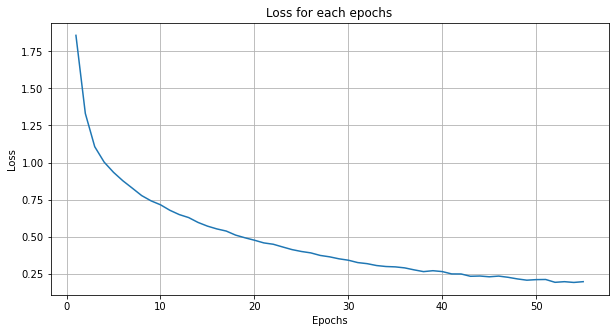

In [79]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, loss_history)
plt.title('Loss for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

In [80]:
dataset_train = SurnamesDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = len(dataset_train), shuffle = True)

correct, total = 0, 0
with torch.no_grad():
  for X_batch, y_batch in train_data:
    pred = model(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1 = f1_score(y_batch.numpy(), predicted.numpy(), average='weighted') # weighted, т.к. дисбаланс классов

print(f'Accuracy: {correct/total}')

print(f'F1: {f1}')

Accuracy: 0.7226775956284153
F1: 0.7139303581258039


In [95]:
X_classmates = ['Semenov', 'Zaraev', 'Ragimov']
y_fictit = [0, 0, 0]

classmats = SurnamesDataset(X_classmates, y_fictit, vocab)
train_data = DataLoader(classmats, batch_size = 1, shuffle = True)

with torch.no_grad():
  for idx, (x, y) in enumerate(train_data):
    out = model(x)
    _, ind = torch.sort(out)
    ind = ind[0]
    print(f'Наиболее вероятные нациаональности для фамилии {X_classmates[idx]}:')
    for id, v in enumerate(ind[-3:]):
      ans = list(set(df[df['label_nationality'] == v.item()]['nationality']))[0]
      print(f'{abs(id - 3)}) {ans}')

Наиболее вероятные нациаональности для фамилии Semenov:
3) German
2) Irish
1) Russian
Наиболее вероятные нациаональности для фамилии Zaraev:
3) Irish
2) Japanese
1) Russian
Наиболее вероятные нациаональности для фамилии Ragimov:
3) Irish
2) Czech
1) Russian


## 3. Классификация обзоров на фильмы (ConvNet)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`


2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [6]:
def read_text(path):
  with open(path, 'r') as pos:
    posit = list()
    for line in pos:
      posit.append(line.rstrip())
    return posit

pos_file = read_text('/content/drive/MyDrive/datasets/polarity/positive_reviews.txt')
df_pos = pd.DataFrame({'review': pos_file, 'label': [0 for i in range(len(pos_file))]})
print(f'count positive reviews: {df_pos.shape[0]}')

neg_file = read_text('/content/drive/MyDrive/datasets/polarity/negative_reviews.txt')
df_neg = pd.DataFrame({'review': neg_file, 'label': [1 for i in range(len(neg_file))]})

print(f'count negative reviews: {df_neg.shape[0]}')

df = pd.concat([df_pos, df_neg], ignore_index=True)

display(df.sample(10)), df.shape

count positive reviews: 5331
count negative reviews: 5331


,review,label
8901,meant for star wars fans . it is there to give...,1
5683,"boisterous , heartfelt comedy .",1
297,this follow-up seems so similar to the 1953 di...,0
9992,to some eyes this will seem like a recycling o...,1
7231,it's a satisfying summer blockbuster and worth...,1
613,"offers no new insight on the matter , nor do i...",0
9390,"more than anything else , kissing jessica stei...",1
64,mattei's underdeveloped effort here is nothing...,0
8501,"this is not chabrol's best , but even his less...",1
5823,"as shaky as the plot is , kaufman's script is ...",1


(None, (10662, 2))

In [7]:
# предобработка текста
for idx, rev in enumerate(df['review']):
  rev = re.sub(r"[^a-zA-Z.,!?[]]", " ", rev)
  rev = re.sub(r"[[]]", "", rev)
  df.loc[idx, 'review'] = rev.lower() 

print(df.shape)
df.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Possible nested set at position 1
  after removing the cwd from sys.path.


(10662, 2)


,review,label
9937,"it's never laugh-out-loud funny , but it is fr...",1
856,snow dogs finds its humour in a black man gett...,0
4738,. . . really horrible drek .,0
42,the effort is sincere and the results are hone...,0
3177,the film's thoroughly recycled plot and tireso...,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size = 0.1, stratify = df['label'])

In [22]:
len(y_train[y_train == 0])/len(y_train), len(y_test[y_test == 0])/len(y_test)

(0.49994788952579466, 0.5004686035613871)

In [23]:
# Скачиваем набор стоп-слов
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lemat = WordNetLemmatizer()

In [25]:
class Vocab:
  def __init__(self, data):
    tokens = [] # Все слова в словаре
    for txt in data:
      for sent in sent_tokenize(txt): # лексемазация предложения
        for word in word_tokenize(sent): # лексемазация слов
          tokens.append(lemat.lemmatize(word,  pos = 'v'))
    
    self.max_seq_len = max([len(word_tokenize(txt)) for txt in data]) # максимальная длина одного отзыва

    tokens = set(tokens)

    # Удаление stop-words in tarin dataset
    stop_words = stopwords.words('english') # Загрузка стоп-слов
    tokens = [word for word in tokens if word not in stop_words]

    self.idx_to_token = {(idx + 1): token for idx, token in enumerate(tokens)}
    self.idx_to_token[0] = '<UNK>'
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()} # токен слово
    self.vocab_len = len(self.idx_to_token)

In [26]:
vocab = Vocab(X_train)
vocab.max_seq_len, vocab.vocab_len

(62, 16265)

In [27]:
class ReviewMovieDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, review):
    '''Генерирует представление отзыва review в виде bag of words (см. 1.2.1)'''
    # ДОПОЛНИТЬ НУЛЯМИ ВЗАДИ
    review_t = torch.zeros(self.vocab.max_seq_len, dtype = int)
    
    for idx, word in enumerate(word_tokenize(review)):
        if word in self.vocab.token_to_idx.keys():
          review_t[idx] = self.vocab.token_to_idx[word]
        else:
          review_t[idx] = self.vocab.token_to_idx['<UNK>']
    
    return review_t

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X[idx]), self.y[idx]

In [28]:
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)
dataset_train[0]

(tensor([ 9517,  9781,  9384, 14324, 13274,     0,     0,  3873,    73,  9517,
          9781, 12571,     0,     0,     0, 14476,  5827,  1162,  9189, 15904,
             0,  9189, 13998,  8678,     0, 13429, 15448,     0,   171, 14058,
             0,     0, 11184,     0, 15877,  6334,  2243, 14476,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]), 0)

In [72]:
class CNNReviewMovieNet(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_classes):
    super().__init__()

    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.layer1 = nn.Sequential(nn.Conv1d(embedding_dim, 128, kernel_size = 2),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.MaxPool1d(2))
    
    # self.layer2 = nn.Sequential(nn.Conv1d(128, 128, 2),
    #                             nn.BatchNorm1d(128),
    #                             nn.ReLU(),
    #                             nn.MaxPool1d(2))

    # self.layer3 = nn.Sequential(nn.Conv1d(128, 64, 2),
    #                             nn.BatchNorm1d(64),
    #                             nn.ReLU(),
    #                             nn.MaxPool1d(2))
    
    self.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(128*30, 256),
                            nn.BatchNorm1d(256),
                            nn.ReLU(),
                            nn.Linear(256, 128),
                            nn.BatchNorm1d(128),
                            nn.Linear(128, 64),
                            nn.BatchNorm1d(64),
                            nn.ReLU(),
                            nn.Linear(64, 64),
                            nn.BatchNorm1d(64),
                            nn.ReLU(),
                            nn.Linear(64, n_classes))
    
  def forward(self, input):
    embed = self.embeddings(input).permute(0, 2, 1) 
    out = self.layer1(embed)
    # out = self.layer2(out)
    # out = self.layer3(out)
    # print(out.shape)
    out = self.fc(out)
    return out

In [82]:
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

vocab_size = vocab.vocab_len
#hidden_size = 512
embedding_dim = 200
n_classes = y_train.nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model  = CNNReviewMovieNet(vocab_size = vocab_size, embedding_dim = embedding_dim, n_classes = n_classes).to(device = device)
criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 4, verbose = False, delta = 0)

loss_history = list()
history_loss_val = list()
epochs_history = list()
accuracy_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  correct_val, total_val = 0, 0
  model.eval()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model(X_val)

      _, predicted = torch.max(out, dim = 1)

      total += y_val.shape[0]
      correct += int((predicted == y_val).sum())

      loss = criteriation(out, y_val)
      loss_val += loss

  history_loss_val.append(loss_val/len(train_data))
  accuracy_val.append(correct/total)

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, Accuracy_Val = {accuracy_val[-1]}')

  early_stop(accuracy_val[-1], model)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, Accuracy_Val = {accuracy_val[-1]}")
      break

torch.save(model, '/content/drive/MyDrive/models/CNN_embedding_ReviewMoves_(b_6_t_3).pth')

Epoch: [1/500]: Loss_Train = 0.700509250164032, Loss_Val = 0.1736937314271927, Accuracy_Val = 0.5539182853315472
Epoch: [3/500]: Loss_Train = 0.6855605244636536, Loss_Val = 0.17191492021083832, Accuracy_Val = 0.5422039859320047
EarlyStopping counter: 1 out of 4
Epoch: [5/500]: Loss_Train = 0.6281858086585999, Loss_Val = 0.16306155920028687, Accuracy_Val = 0.5588069780528981
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
Epoch: [7/500]: Loss_Train = 0.4127388000488281, Loss_Val = 0.17338353395462036, Accuracy_Val = 0.5788965517241379
EarlyStopping counter: 4 out of 4
Early stopping on epoch: [7/500] with Loss_Train = 0.4127388000488281, Loss_Val = 0.17338353395462036, Accuracy_Val = 0.5788965517241379


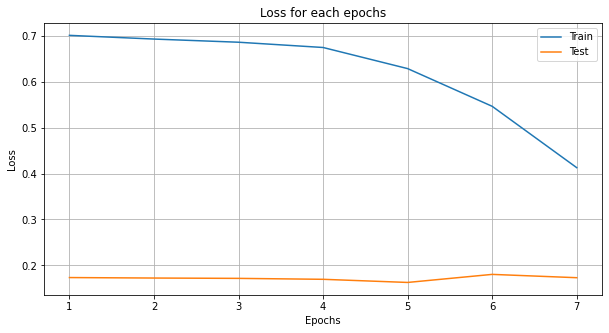

In [83]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, loss_history, label = 'Train')
plt.plot(epochs_history, history_loss_val, label = 'Test')
plt.legend()
plt.title('Loss for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

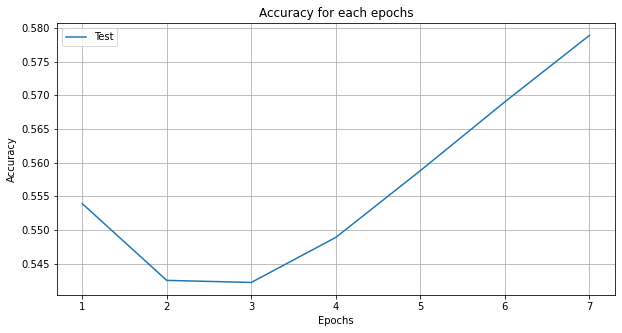

In [84]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, accuracy_val, label = 'Test')
plt.legend()
plt.title('Accuracy for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

In [85]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = len(dataset_train), shuffle = True)

correct, total = 0, 0
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    # f1 = f1_score(y_batch.numpy(), predicted.numpy(), average='weighted') # weighted, т.к. дисбаланс классов

print(f'Accuracy: {correct/total}')

# print(f'F1: {f1}')

Accuracy: 0.6672914714151827


In [90]:
negative = 'The acting is bad because the idea of ​​the film is terrible.'
# negative = preprocess_text(negative)
positive = 'The director made a masterpiece.'
# positive = preprocess_text(positive)

X_classmates = [negative, positive]
y_fictit = [0, 0]

reviews = ReviewMovieDataset(X_classmates, y_fictit, vocab)
rev = DataLoader(reviews, batch_size = 1, shuffle = True)

with torch.no_grad():
  for x, y in rev:
    x, y = x.to(device = device), x.to(device = device)
    out = model(x)
    _, predicted = torch.max(out, dim = 1)
    
    print(predicted.item())

# 0 - позитивный отзыв
# 1 - негативный отзыв

0
0
